In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
#connecting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create directory
! mkdir ~/.kaggle

In [ ]:
data_dir="/content/"

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_api/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
#permission
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#data set
! kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [00:14<00:00, 124MB/s]
100% 1.69G/1.69G [00:14<00:00, 126MB/s]


In [ ]:
#unzipping content
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [ ]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [ ]:
!ls

drive				    sample_data		   test
plant-seedlings-classification.zip  sample_submission.csv  train


In [ ]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987

In [ ]:
train_dir="/content/train"


In [ ]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))


Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

(4750, 3)

In [ ]:

train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

(2400, 3)

In [ ]:
test_dir="/content/test"

In [ ]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

(794, 2)

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

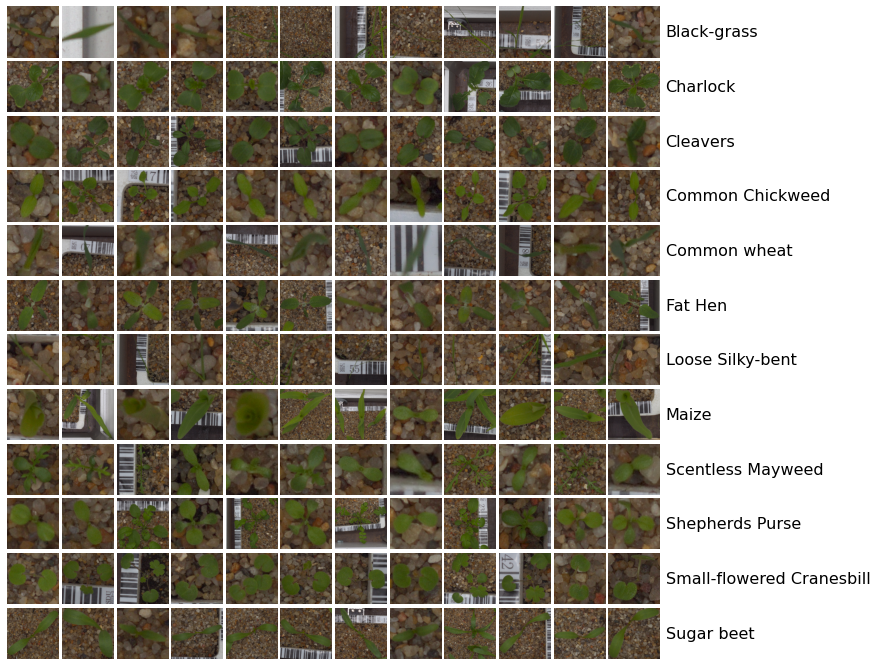

In [ ]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();



In [ ]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [ ]:
from keras.applications.mobilenet import MobileNet,preprocess_input, decode_predictions
INPUT_SIZE=224
POOLING='avg'
x_train=np.zeros((len(train),INPUT_SIZE,INPUT_SIZE,3),dtype=np.float32)
for i,file in tqdm(enumerate(train['file'])):
    img = read_img(os.path.join(file),(INPUT_SIZE,INPUT_SIZE))
    x=preprocess_input(np.expand_dims(img.copy(),axis=0)) #need to be changed for every model
    x_train[i]=x
print('Train image shape: {} size: {:,}'.format(x_train.shape,x_train.size))

2400it [00:34, 68.96it/s]

Train image shape: (2400, 224, 224, 3) size: 361,267,200


In [ ]:
xtrain=x_train[train_idx]
xvalid=x_train[valid_idx]
print((xtrain.shape,xvalid.shape))

((1899, 224, 224, 3), (501, 224, 224, 3))


In [ ]:
from keras.preprocessing import image
mobile_bottleneck = MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
train_mobile_bf = mobile_bottleneck.predict(xtrain, batch_size=32, verbose=1)
valid_mobile_bf = mobile_bottleneck.predict(xvalid, batch_size=32, verbose=1)
print('mobile train bottleneck features shape: {} size: {:,}'.format(train_mobile_bf.shape, train_mobile_bf.size))
print('mobile valid bottleneck features shape: {} size: {:,}'.format(valid_mobile_bf.shape, valid_mobile_bf.size))

16/16 [==============================] - 16s 985ms/step
mobile train bottleneck features shape: (1899, 7, 7, 1024) size: 95,284,224
mobile valid bottleneck features shape: (501, 7, 7, 1024) size: 25,138,176


In [ ]:
train_mobile_bf=train_mobile_bf.reshape(1899,50176)
valid_mobile_bf=valid_mobile_bf.reshape(501,50176)

In [ ]:
import keras
from keras import utils as np_utils
one_hot_labels = keras.utils.np_utils.to_categorical(ytr, num_classes=12)
valid_labels = keras.utils.np_utils.to_categorical(yv, num_classes=12)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=50176, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=12))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1000)              50177000  
                                                                 
 dense_28 (Dense)            (None, 500)               500500    
                                                                 
 dense_29 (Dense)            (None, 150)               75150     
                                                                 
 dense_30 (Dense)            (None, 12)                1812      
                                                                 
 activation_5 (Activation)   (None, 12)                0         
                                                                 
Total params: 50,754,462
Trainable params: 50,754,462
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8
19/19 [==============================] - 12s 591ms/step - loss: 2.2525 - accuracy: 0.2717 - val_loss: 1.9727 - val_accuracy: 0.4351
Epoch 2/8
19/19 [==============================] - 11s 567ms/step - loss: 1.7367 - accuracy: 0.5761 - val_loss: 1.5472 - val_accuracy: 0.5629
Epoch 3/8
19/19 [==============================] - 15s 799ms/step - loss: 1.2835 - accuracy: 0.7372 - val_loss: 1.1664 - val_accuracy: 0.7425
Epoch 4/8
19/19 [==============================] - 11s 564ms/step - loss: 0.8487 - accuracy: 0.8699 - val_loss: 0.8103 - val_accuracy: 0.8244
Epoch 5/8
19/19 [==============================] - 11s 566ms/step - loss: 0.4668 - accuracy: 0.9373 - val_loss: 0.5804 - val_accuracy: 0.8483
Epoch 6/8
19/19 [==============================] - 11s 568ms/step - loss: 0.2112 - accuracy: 0.9774 - val_loss: 0.4555 - val_accuracy: 0.8683
Epoch 7/8
19/19 [==============================] - 11s 567ms/step - loss: 0.0958 - accuracy: 0.9905 - val_loss: 0.4426 - val_accuracy: 0.8523
Epoch 

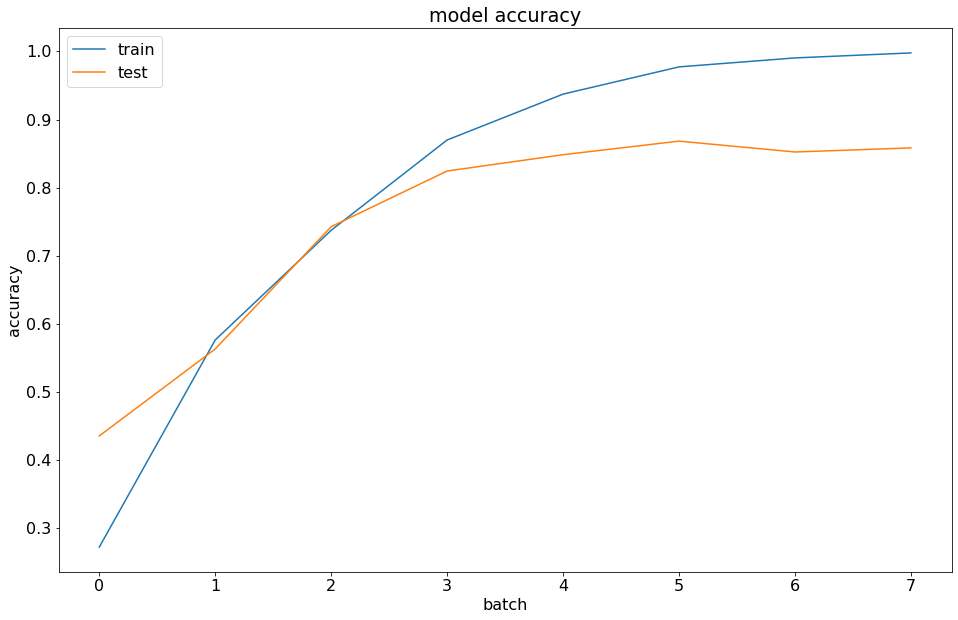

In [ ]:
history= model.fit(train_mobile_bf,one_hot_labels, epochs=8, batch_size=100,validation_data=(valid_mobile_bf, valid_labels))
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save_weights('fc_model.h5')